In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from src.anfis_sa import ANFISPredictor

In [3]:
path = "./data/concrete/Concrete_Data_Yeh.csv"
target = 'csMPa'

In [4]:
df = pd.read_csv(path)
df = df.dropna()

# EDA

In [5]:
df_summary = df.describe()
df_summary

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


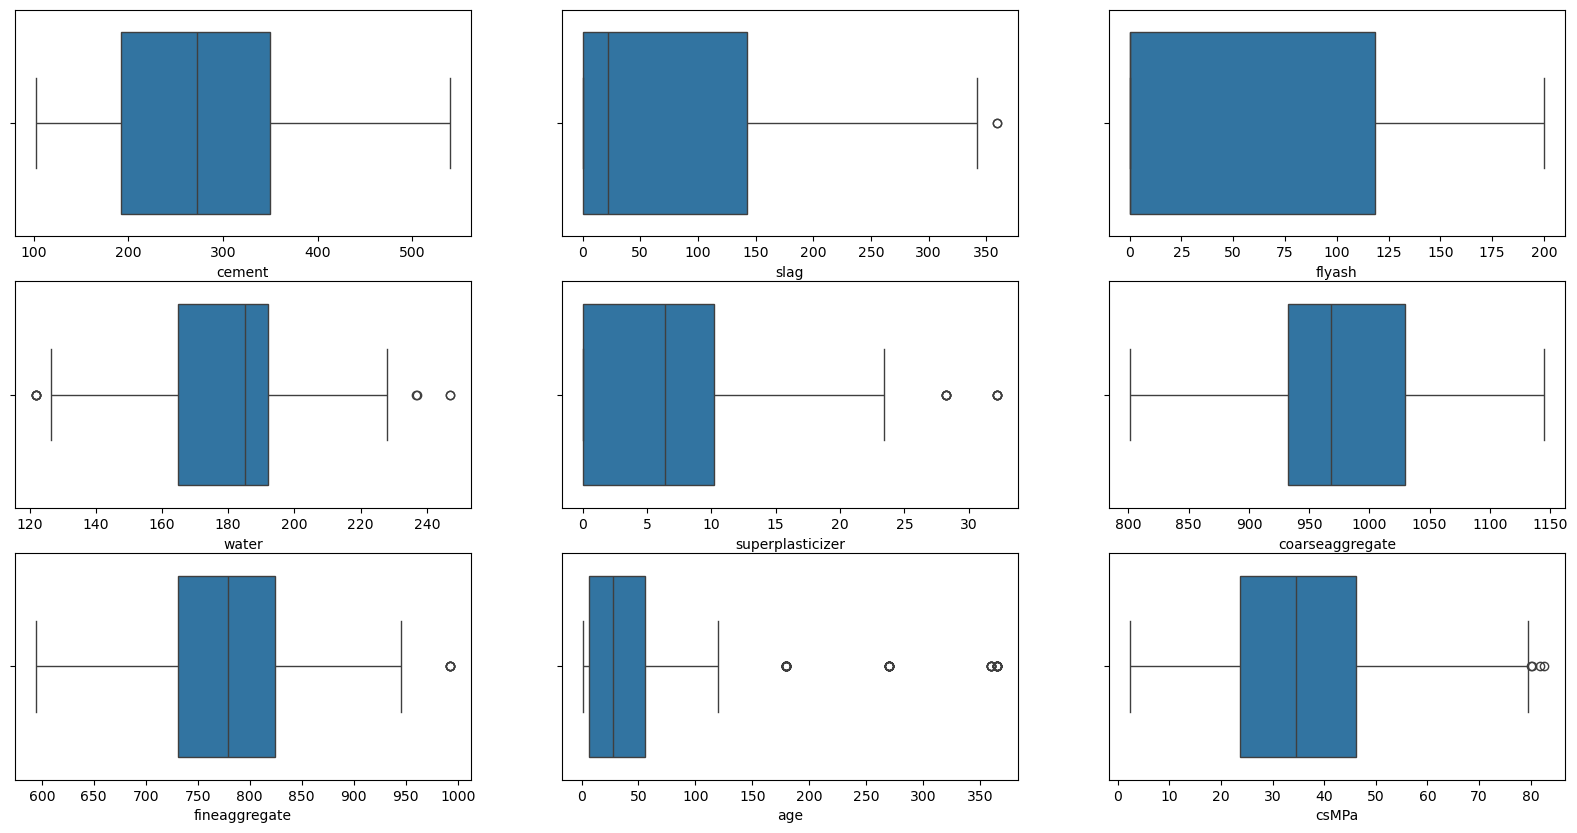

In [6]:
# plot each column's data distribution
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(3, 3, figsize = (20,10));
col_cnt = 0
col_names = df.columns.tolist()
for r in range(3):
    for c in range(3):
        try:
            sns.boxplot(df[col_names[col_cnt]], ax=axes[r][c], orient="h");
            col_cnt += 1
        except:
            pass

In [7]:
# removing outliers
outlier_cols = ["slag", "water", "superplasticizer", "fineaggregate", "age"]
def cap_outliers(df, col):
    """
    Cap the outliers in the column by replacing them with the mean of the column.
    """
    q1 = df_summary[col].loc["25%"]
    q3 = df_summary[col].loc["75%"]
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df.loc[df[col] < lower_bound, col] = df_summary[col].loc["mean"]
    df.loc[df[col] > upper_bound, col] = df_summary[col].loc["mean"]
    return df
    
    
for col in outlier_cols:
    df = cap_outliers(df, col)

/tmp/ipykernel_54004/270838131.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '45.662135922330094' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] < lower_bound, col] = df_summary[col].loc["mean"]


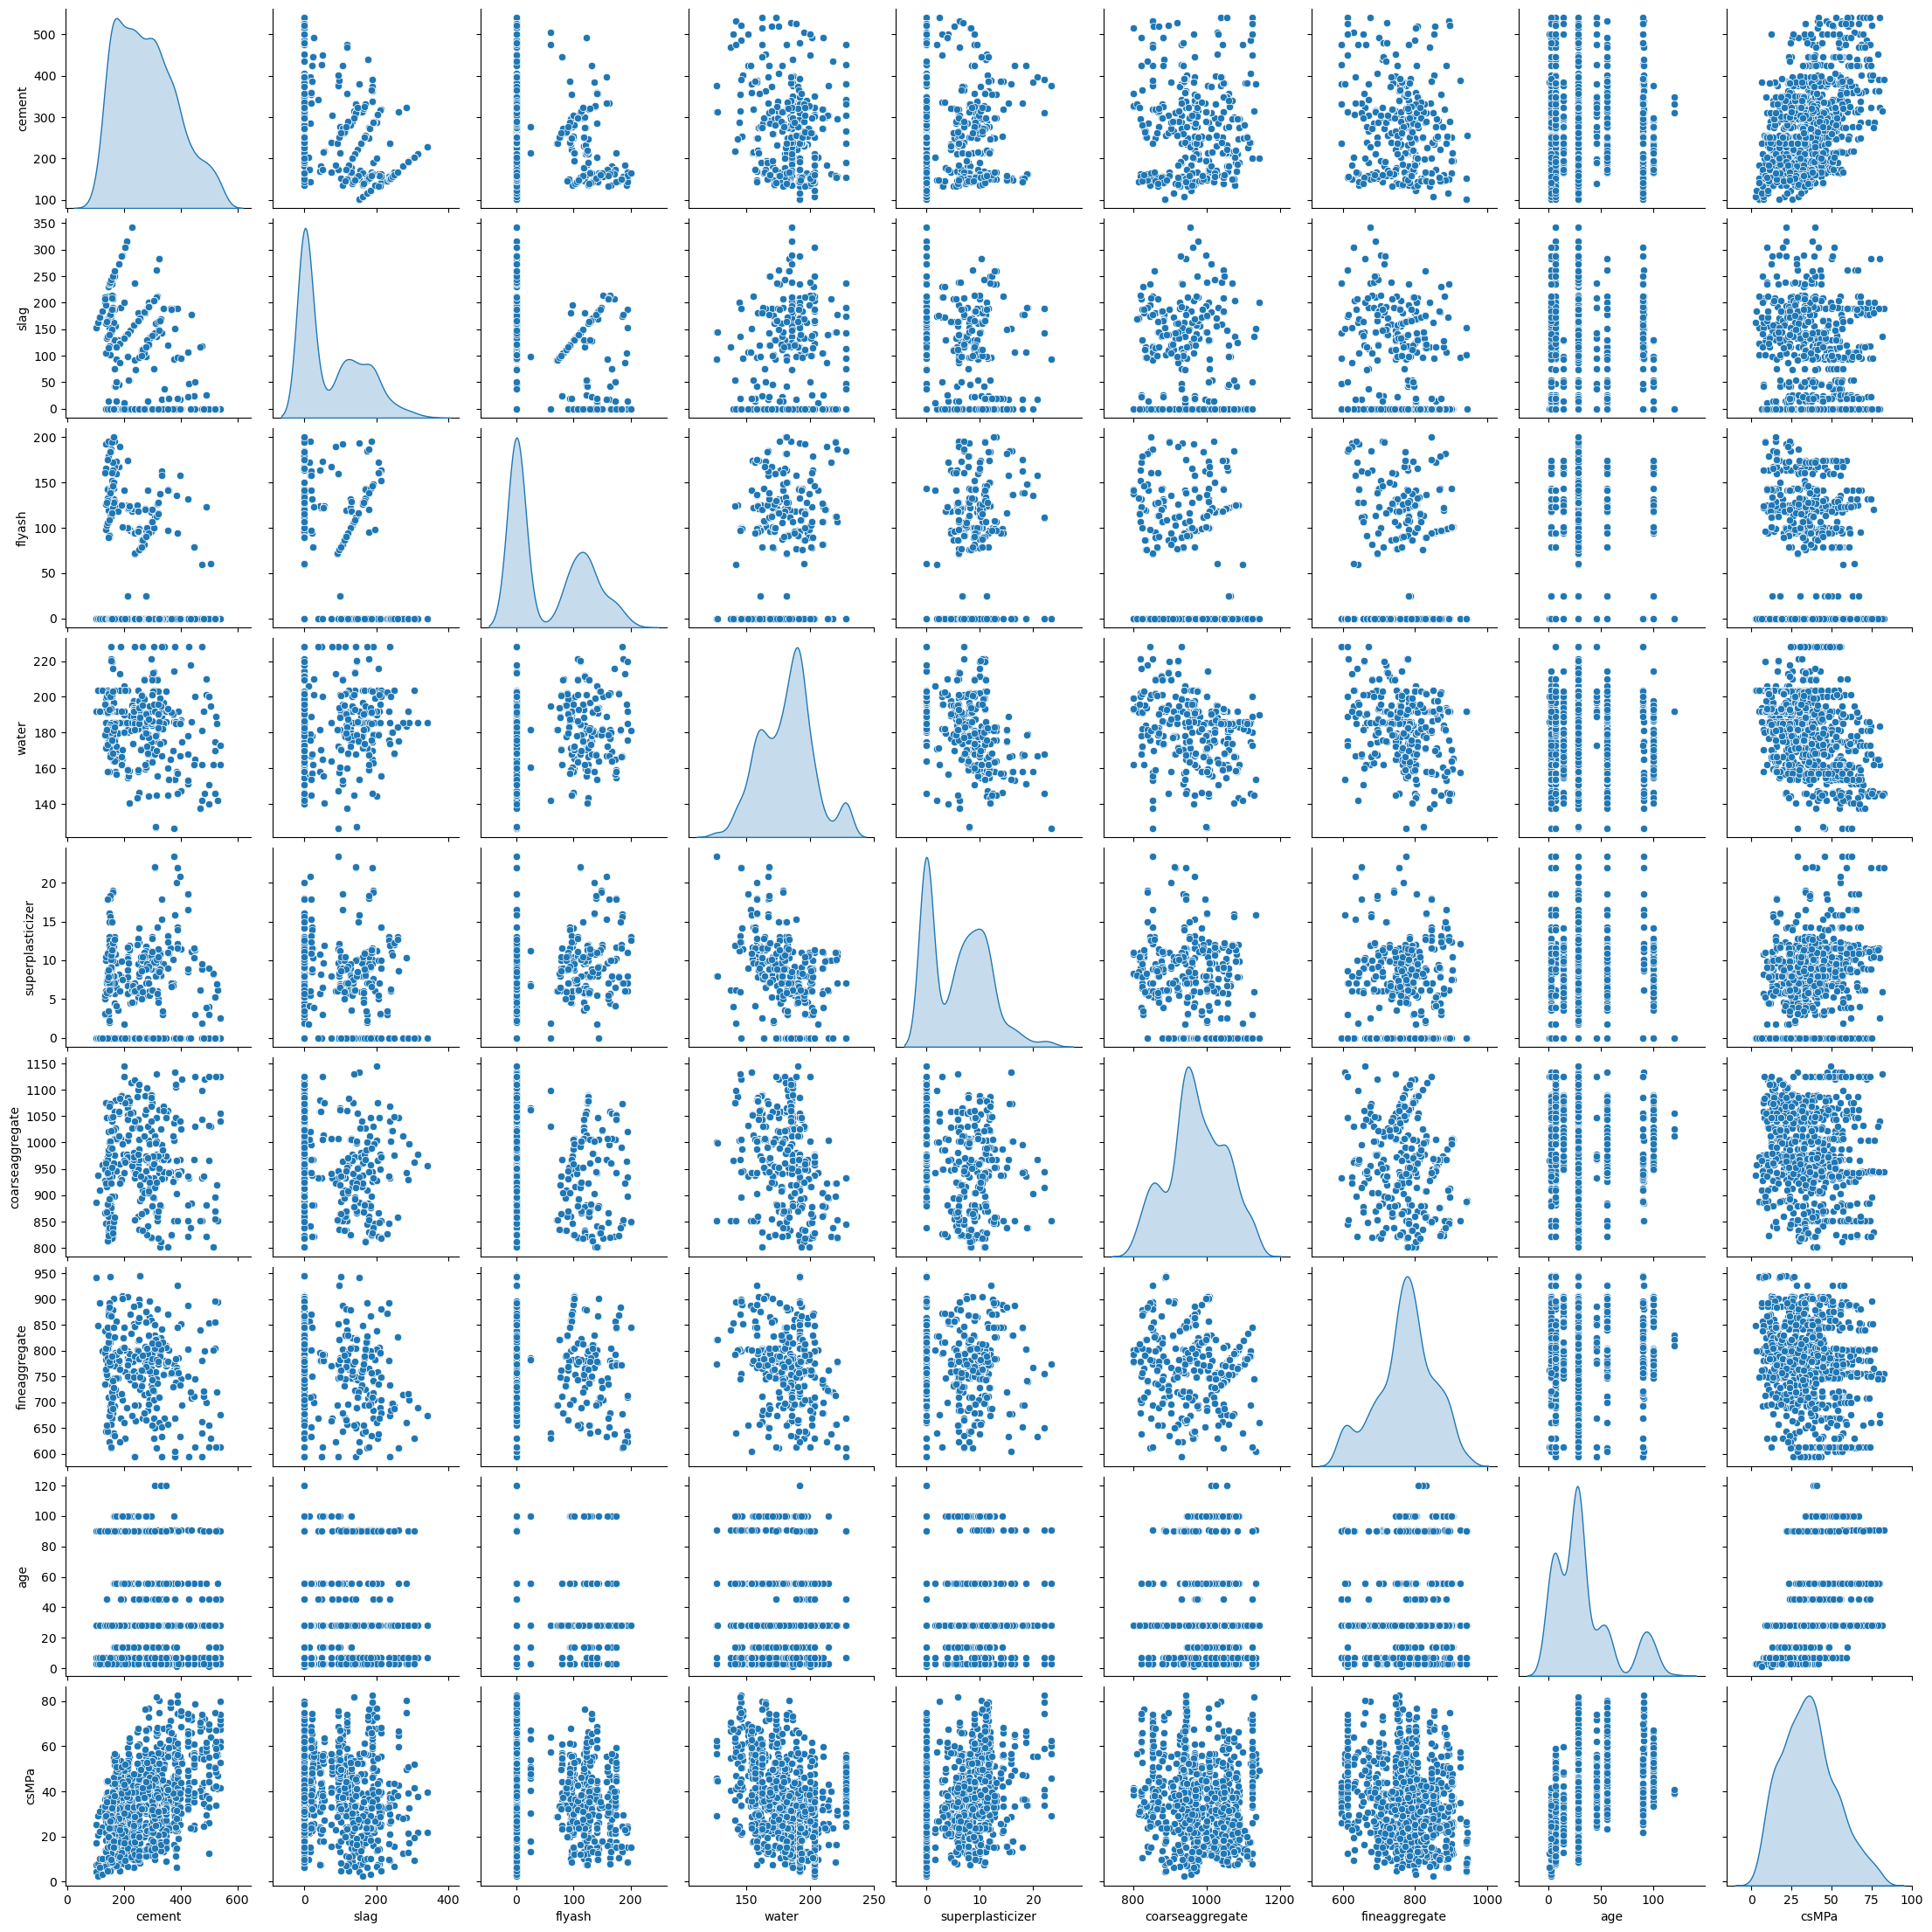

In [8]:
sns.pairplot(df, diag_kind="kde")

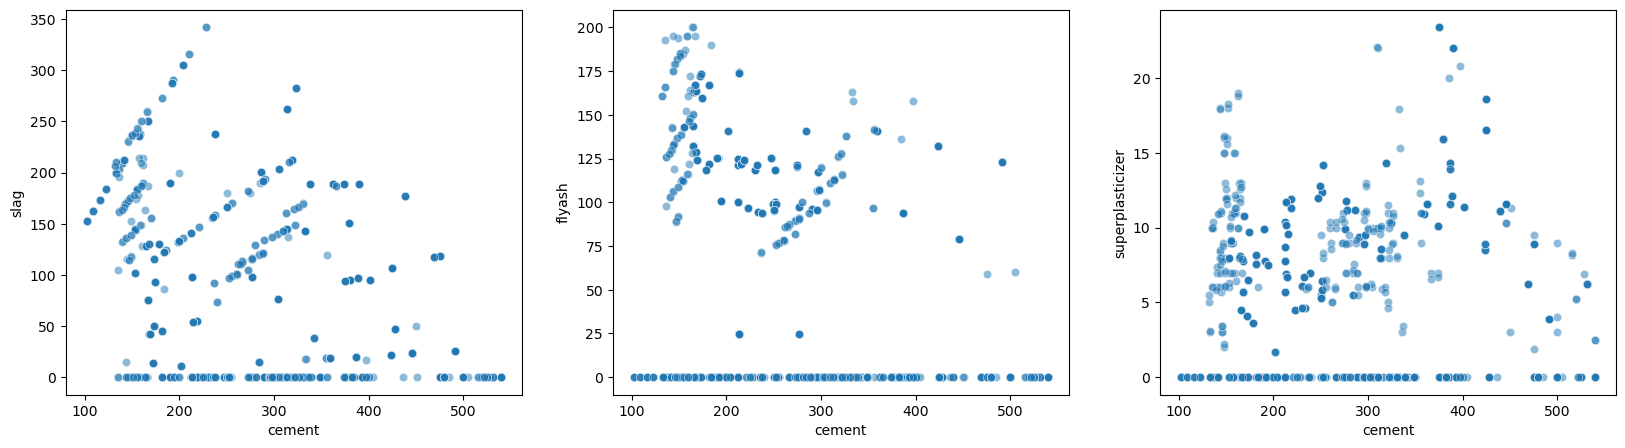

In [9]:
fig, axes = plt.subplots(1, 3, figsize = (20,5));

sns.scatterplot(y="slag", x="cement", data=df, ax=axes[0], alpha=0.5);
sns.scatterplot(y="flyash", x="cement", data=df, ax=axes[1], alpha=0.5);
sns.scatterplot(y="superplasticizer", x="cement", data=df, ax=axes[2], alpha=0.5);

In [10]:
def impute_values(alg, df, a, cols):
    df[a] = df[a].replace({0: np.nan})
    df_notnull = df[df[a].notna()]
    
    X = df_notnull[cols]
    y = df_notnull[a]
    
    df_null = df[df[a].isna()]
    test_X = df_null[cols]

    regr = alg
    regr.fit(X, y)

    pred = regr.predict(test_X)
    df_null = df[df[a].isna()]
    df_null[a] = pred
    
    xx = df[df[a].notna()]
    xx["null"] = 0
    df_null["null"] = 1
    df = pd.concat([xx, df_null], axis=0)
    cols.append(a)
    return df

/tmp/ipykernel_54004/3201635759.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null[a] = pred
/tmp/ipykernel_54004/3201635759.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xx["null"] = 0
/tmp/ipykernel_54004/3201635759.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

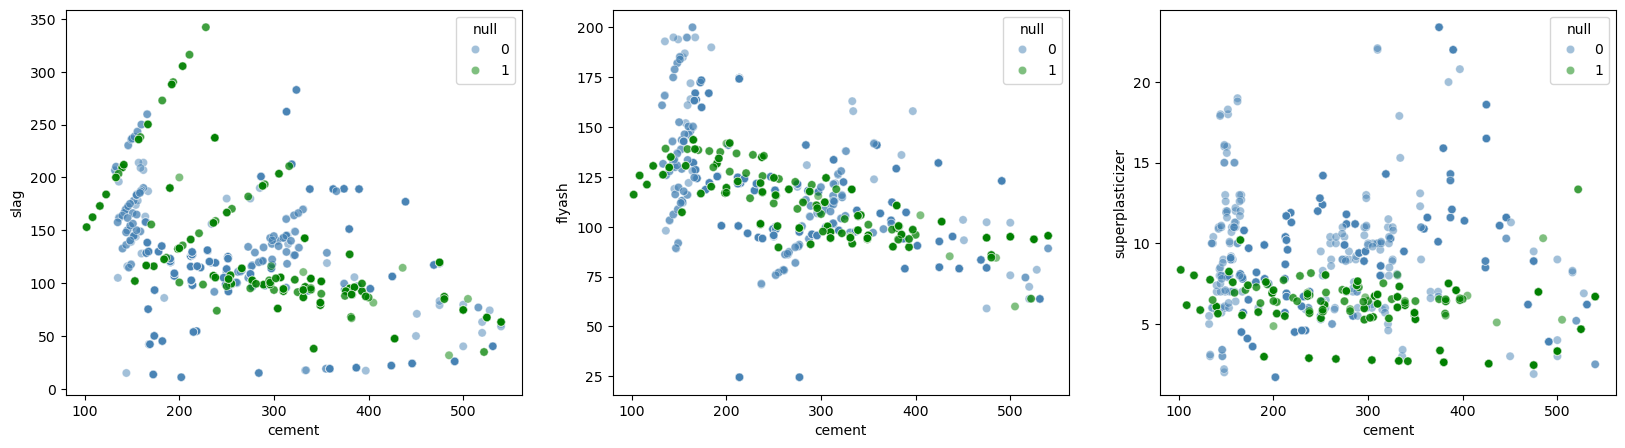

In [11]:
from sklearn.linear_model import LinearRegression
for col, params in {"flyash": ["cement", "water", "fineaggregate"], "slag": ["cement", "coarseaggregate", "fineaggregate"], "superplasticizer" : ["cement", "water", "coarseaggregate"]}.items():
    alg = LinearRegression()
    df = impute_values(alg, df, col, params)
    
fig, axes = plt.subplots(1, 3, figsize = (20,5))

sns.scatterplot(y="slag", x="cement", data=df, hue="null", ax=axes[0], alpha=0.5, palette=["steelblue", "green"])
sns.scatterplot(y="flyash", x="cement", data=df, hue="null", ax=axes[1], alpha=0.5, palette=["steelblue", "green"])
sns.scatterplot(y="superplasticizer", x="cement", data=df, hue="null", ax=axes[2], alpha=0.5, palette=["steelblue", "green"])
plt.show()

In [12]:
df_copy = df.copy()
df_copy["cement_water_ratio"] = df_copy["cement"]/df_copy["water"]
df_copy["average_agg"] = (df_copy["coarseaggregate"] + df_copy["fineaggregate"])/2
df_copy.drop(columns=["cement", "water", "coarseaggregate", "fineaggregate"], inplace=True)

In [16]:
target_col = ["csMPa"]
col_names = df_copy.columns.to_list()
col_names.remove(target_col[0])

<Axes: >

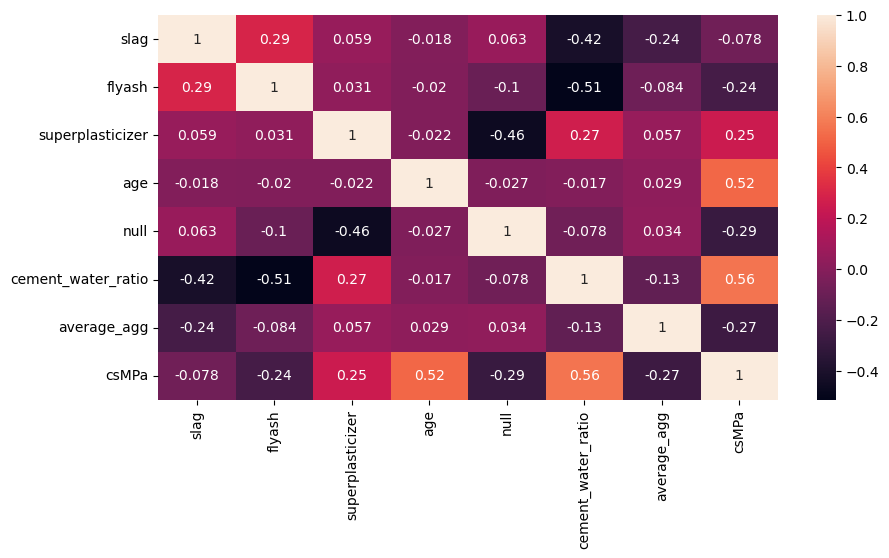

In [19]:
plt.figure(figsize=(10,5))
sns.heatmap(df_copy[col_names + target_col].corr(), fmt=".2g", annot=True)

In [22]:
df_copy.drop(columns=["null"], inplace=True)
df_copy.head()

,slag,flyash,superplasticizer,age,csMPa,cement_water_ratio,average_agg
224,42.1,163.8,5.7,3.0,7.75,0.925277,919.4
225,42.1,163.8,5.7,14.0,17.82,0.925277,919.4
226,42.1,163.8,5.7,28.0,24.24,0.925277,919.4
227,42.1,163.8,5.7,56.0,32.85,0.925277,919.4
228,42.1,163.8,5.7,100.0,39.23,0.925277,919.4


In [23]:
from src.anfis_sa import ANFISPredictor
model = ANFISPredictor(
        target_column='csMPa',      # The target column
        hidden_dims=[256, 128, 64],  # Custom architecture
        use_attention=True,          # Enable self-attention
        attention_dim=32,            # Custom attention dimension
        num_rules=7,                 # Custom number of ANFIS rules
        dropout_rate=0.2            # Add dropout for regularization
    )

In [24]:
train_df, test_df = train_test_split(df_copy, test_size=0.2, random_state=42)

In [25]:
model.fit(train_df, epochs=100, batch_size=4, learning_rate=1e-3)

Epoch [10/100], Average Loss: 0.0150
Epoch [20/100], Average Loss: 0.0118
Epoch [30/100], Average Loss: 0.0095
Epoch [40/100], Average Loss: 0.0087
Epoch [50/100], Average Loss: 0.0075
Epoch [60/100], Average Loss: 0.0068
Epoch [70/100], Average Loss: 0.0060
Epoch [80/100], Average Loss: 0.0055
Epoch [90/100], Average Loss: 0.0054
Epoch [100/100], Average Loss: 0.0050


In [26]:
# eval
y_pred = model.predict(test_df)
y_true = test_df['csMPa'].values
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"MSE: {mse:.2f}, R2: {r2:.2f}")

MSE: 54.08, R2: 0.83
